In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
# from torchvision import transforms
# from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from utils_v import compute_target_score, estimate_target, save_model, standardize_dataset
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, MLP
from dev_losses import cauchy, rbf, gaussian_kernel, CustomSupCon, CustomContrastiveLoss
from losses import KernelizedSupCon

## Noise: mean & std of nearest neighbors

In [ ]:
from sklearn.neighbors import NearestNeighbors

features  = np.load("vectorized_matrices_la5c.npy")
n_neighbors = 10
nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(features)
distances, indices = nbrs.kneighbors(features)

# Calculate the std of the nearest neighbors for each sample, excluding the point itself
std_neighbors = np.array([np.std(features[indices[i, 1:]], axis=0) for i in range(features.shape[0])]).mean(axis = 1)
mean_neighbors = np.array([np.mean(features[indices[i, 1:]], axis=0) for i in range(features.shape[0])]).mean(axis = 1)


# Calculate the mean std of neighbors as your Gaussian noise std
mean_std = np.mean(std_neighbors)
median_std = np.median(std_neighbors)

mean_of_means = np.mean(mean_neighbors)
median_of_means = np.median(mean_neighbors)


fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Standard Deviations
axs[0].hist(std_neighbors, bins=30, alpha=0.75, color='blue')
axs[0].axvline(mean_std, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_std:.2f}')
axs[0].axvline(median_std, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_std:.2f}')
axs[0].set_title(f'Distribution of Standard Deviations for {n_neighbors} neighbors')
axs[0].set_xlabel('Standard Deviation')
axs[0].set_ylabel('Frequency')
axs[0].legend()
axs[0].grid(True)

# Plot for Means
axs[1].hist(mean_neighbors, bins=30, alpha=0.75, color='orange')
axs[1].axvline(mean_of_means, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_of_means:.2f}')
axs[1].axvline(median_of_means, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_of_means:.2f}')
axs[1].set_title(f'Distribution of Means for {n_neighbors} neighbors')
axs[1].set_xlabel('Mean')
axs[1].set_ylabel('Frequency')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


## Guassian Noise Augmentation

In [22]:
class AugGaussianNoise(object):
    def __init__(self, mean=0.16, std=0.18):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [62]:
class MatData(Dataset):
    def __init__(self, path_feat, path_target, transform = None, train=True, train_size = 0.8, test_size=None, random_state=42):
        """
        Initializes the dataset with the capability to handle training and testing splits, 
        including multiple views for augmented data.
        
        Args:
            path_feat (str): Path to the features file.
            path_target (str): Path to the target file.
            transform (callable): A transformation function to apply for augmentation.
            train (bool): Whether the dataset is used for training. False will load the test set.
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Random state for reproducible train-test splits.
        """
        # Load the entire dataset
        features = np.load(path_feat)
        targets = np.load(path_target)

        # Split the dataset into training and test sets
        train_indices, test_indices = train_test_split(np.arange(len(features)), 
                                                       train_size = train_size,
                                                       test_size=test_size,                
                                                       random_state=random_state)
        
        if train:
            selected_indices = train_indices
        else:
            selected_indices = test_indices
        
        # Select the subset of data for the current mode (train/test)
        features = features[selected_indices]
        features = torch.from_numpy(features).float()
        targets = targets[selected_indices]
        targets = torch.from_numpy(targets).float()
        

        self.n_sub = len(features)
        self.n_features = features.shape[-1]
        self.n_views = 1
        self.transform = transform
        self.targets = targets
        
        if train:
            # augmentation only in training mode
            augmented_features = self.transform(features)

            if len(augmented_features.shape) < 3:
                self.n_views = self.n_views + 1
                augmented_features = augmented_features.unsqueeze(1)
            else:
                self.n_views = self.n_views + augmented_feature[0]
            self.features = np.zeros((self.n_sub, self.n_views, self.n_features))
            self.features[:, 0, :] = features
            self.features[:, 1:, :] = augmented_features
            self.features = torch.from_numpy(self.features).float()
        else:
            self.features = features
                
    def __len__(self):
        return self.n_sub

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        return features, targets


## Noise: Rank of covar matrix

In [25]:
# def compute_rank_of_covariance(X, n_neighbors=5):
#     """
#     Compute the rank of the covariance matrix of nearest neighbors for each sample in X.
    
#     Parameters:
#     - X: numpy array of shape (n_samples, n_features), the dataset.
#     - n_neighbors: int, the number of nearest neighbors to consider.
    
#     Returns:
#     - ranks: numpy array of shape (n_samples,), the rank of the covariance matrix for each sample.
#     """
#     nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, algorithm='auto').fit(X)
#     _, indices = nbrs.kneighbors(X)
    
#     ranks = np.zeros(X.shape[0])
    
#     for i in range(X.shape[0]):
#         # Extract the nearest neighbors for the current sample, excluding the sample itself
#         neighbors = X[indices[i, 1:]]  # Skip the first neighbor (the point itself)
        
#         # Compute the covariance matrix of the neighbors
#         cov_matrix = np.cov(neighbors, rowvar=False)
        
#         # Compute the rank of the covariance matrix
#         ranks[i] = np.linalg.matrix_rank(cov_matrix)
    
#     return ranks


# ranks = compute_rank_of_covariance(features, n_neighbors=5)
# plt.hist(ranks, bins=np.arange(ranks.min(), ranks.max()+1), alpha=0.75, color='green')
# plt.title('Distribution of Covariance Matrix Ranks Among Nearest Neighbors')
# plt.xlabel('Rank')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
!pwd

In [26]:
aug = AugGaussianNoise(mean=0.16, std=0.15)
# test_dataset = MatData("vectorized_matrices_la5c.npy", "hopkins_age.npy", train=False)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str, krnl_sigma = None, temperature: float=0.07, contrast_mode: str='all',
                 base_temperature: float=0.07, kernel: callable=None, delta_reduction: str='sum'):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.delta_reduction = delta_reduction
        self.krnl_sigma = krnl_sigma

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction}, ' \
               f'krnl_sigma={self.krnl_sigma}'
                

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, n_features]. 
                input has to be rearranged to [bsz, n_views, n_features] and labels [bsz],
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 3:
            raise ValueError('`features` needs to be [bsz, n_views, n_feats],'
                             '3 dimensions are required')

        batch_size = features.shape[0]
        n_views = features.shape[1]

        if labels is None:
            mask = torch.eye(batch_size, device=device)
        
        else:
            # labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError(f'Num of labels does not match num of features: {labels.shape[0]} vs. {batch_size}')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T)
            else:
                mask = self.kernel(labels, self.krnl_sigma)
            
        view_count = features.shape[1]
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            features = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            features = features
            anchor_count = view_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # Tile mask
        mask = mask.repeat(anchor_count, view_count)

        # Inverse of torch-eye to remove self-contrast (diagonal)
        inv_diagonal = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size*n_views, device=device).view(-1, 1),
            0
        )

        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features.T),
            self.temperature
        )
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        alignment = logits 

        # base case is:
        # - supcon if kernel = none 
        # - y-aware is kernel != none
        uniformity = torch.exp(logits) * inv_diagonal

        if self.method == 'threshold':
            repeated = mask.unsqueeze(-1).repeat(1, 1, mask.shape[0]) # repeat kernel mask

            delta = (mask[:, None].T - repeated.T).transpose(1, 2) # compute the difference w_k - w_j for every k,j
            delta = (delta > 0.).float()

            # for each z_i, repel only samples j s.t. K(z_i, z_j) < K(z_i, z_k)
            uniformity = uniformity.unsqueeze(-1).repeat(1, 1, mask.shape[0])
            
            
            if self.delta_reduction == 'mean':
                uniformity = (uniformity * delta).mean(-1)
            else:
                uniformity = (uniformity * delta).sum(-1)
                
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))
        # positive mask contains the anchor-positive pairs
        # excluding <self,self> on the diagonal
        positive_mask = mask * inv_diagonal

        log_prob = alignment - uniformity # log(alignment/uniformity) = log(alignment) - log(uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1) # compute mean of log-likelihood over positive
 
        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()

    

In [30]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
input_dim_target = 60
# the rest is arbitrary
hidden_dim_feat = 1000
hidden_dim_target = 30
output_dim = 2

num_epochs = 100

lr = 0.001 # too low values return nan loss
kernel = gaussian_kernel
batch_size = 5 # too low values return nan loss
dropout_rate = 0

In [31]:
def gaussian_kernel(x, krnl_sigma):
    kernelized = []
    for var in x.T:
        krnl_var = var.unsqueeze(-1).T - var.unsqueeze(-1)
        kernelized.append(krnl_var)
    kernelized = sum([krnl_var**2 for krnl_var in kernelized])
    return torch.exp(-kernelized / (2*(krnl_sigma**2))) / (math.sqrt(krnl_sigma*torch.pi)*krnl_sigma)

In [32]:
def standardize_dataset(dataset):
    # Flatten the dataset across subjects and views to simplify standardization across features
    all_features_flat = torch.cat([dataset[i][0].view(-1, dataset[i][0].shape[-1]) for i in range(len(dataset))], dim=0)
    all_targets = torch.cat([dataset[i][1].unsqueeze(0) for i in range(len(dataset))], dim=0)
    
    # Calculate mean and std dev for each feature across all subjects and views
    features_mean = all_features_flat.mean(dim=0)
    features_std = all_features_flat.std(dim=0)
    
    # Ensure no division by zero
    features_std[features_std == 0] = 1
    
    # Initialize containers for standardized features
    standardized_features_list = []
    
    # Apply standardization to each sample
    for i in range(len(dataset)):
        features = dataset[i][0].view(-1, dataset[i][0].shape[-1])  # Flatten views for standardization
        # Standardize
        standardized_features = (features - features_mean) / features_std
        # Reshape back to original [n_views, n_feat] and store
        standardized_features_list.append(standardized_features.view(dataset[i][0].shape))
    
    # Stack standardized features to match original dataset structure [n_sub, n_views, n_feat]
    standardized_features = torch.stack(standardized_features_list)
    
    # Targets don't change structure, so we just use the original targets here
    standardized_dataset = TensorDataset(standardized_features, all_targets)
    
    return standardized_dataset


In [33]:
train_dataset = MatData("vectorized_matrices_la5c.npy", "hopkins_covars.npy", train=True, train_size = 15,transform=aug)
test_dataset = MatData("vectorized_matrices_la5c.npy", "hopkins_covars.npy",test_size = 5, train=False)

standardized_train_dataset = standardize_dataset(train_dataset)
std_train_loader = DataLoader(standardized_train_dataset, batch_size=batch_size, shuffle=True)

standardized_test_dataset = standardize_dataset(test_dataset)
std_test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [34]:
# torch.cuda.empty_cache()
model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim, dropout_rate = 0).to(device)
criterion_pft = KernelizedSupCon(method='expw', temperature=0.01, base_temperature=0.01, kernel=kernel, krnl_sigma = 1)
criterion_ptt = KernelizedSupCon(method='expw', temperature=0.01, base_temperature=0.01, kernel=kernel, krnl_sigma = 1)

# criterion = CustomKernelizedSupCon(temperature = temperature, base_temperature = base_temperature, kernel = kernel)
# criterion = CustomSupCon('exp',temperature = temperature, base_temperature = base_temperature, kernel = kernel)

optimizer = optim.Adam(model.parameters(), lr=lr)
for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for batch_num, (features, targets) in enumerate(std_train_loader):
        bsz = targets.shape[0]
        n_views = features.shape[1]
        n_feat = features.shape[-1]
        
        features = features.view(bsz * n_views, n_feat) # [bsz*2, 499500]
        features, targets = features.to(device), targets.to(device) # [bsz, 2, 499500], [bsz, 60]
        
        optimizer.zero_grad()
        out_feat, out_target = model(features, torch.cat([targets, targets], dim=0)) # ([bsz*2, 2], [bsz*2, 60])
        
        out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
        out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1) # [bsz, 2, 2]
        
        loss = criterion_pft(out_feat, targets) # ([bsz, 2, 2], [bsz, 60])
        
        out_target = torch.split(out_target, [bsz]*n_views, dim=0)
        out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1) # [bsz, 2, 2]
        
        loss += criterion_ptt(out_target, targets) # ([bsz, 2, 2], [bsz, 60])
        loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2)) # mse_loss([bsz*2, 2], [bsz*2, 2])
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        batch_losses.append(loss.item())
        optimizer.step()
    print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')


mape_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'mape')
r2_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'r2')
# results_cv.append(['Overall', mape_train, r2_train, mape_val, r2_val])
print(mape_train, r2_train)


Epoch 0 | Mean Loss 144.02464040120444
Epoch 1 | Mean Loss 141.02452596028647
Epoch 2 | Mean Loss 111.45223744710286
Epoch 3 | Mean Loss 123.26609802246094
Epoch 4 | Mean Loss 103.52383931477864
Epoch 5 | Mean Loss 47.42347208658854
Epoch 6 | Mean Loss 39.88684972127279
Epoch 7 | Mean Loss 31.696186701456707
Epoch 8 | Mean Loss 25.059825897216797
Epoch 9 | Mean Loss 27.2372891108195
Epoch 10 | Mean Loss 16.101516723632812
Epoch 11 | Mean Loss 14.147429784138998
Epoch 12 | Mean Loss 19.786001205444336
Epoch 13 | Mean Loss 13.221532503763834
Epoch 14 | Mean Loss 7.995614687601726
Epoch 15 | Mean Loss 9.749869664510092
Epoch 16 | Mean Loss 13.29816977183024
Epoch 17 | Mean Loss 7.502921899159749
Epoch 18 | Mean Loss 7.798559029897054
Epoch 19 | Mean Loss 8.063296635945639
Epoch 20 | Mean Loss 8.533267339070639
Epoch 21 | Mean Loss 7.735104878743489
Epoch 22 | Mean Loss 7.008580048878987
Epoch 23 | Mean Loss 5.54757301012675
Epoch 24 | Mean Loss 5.3606077035268145
Epoch 25 | Mean Loss 5.55

In [64]:
# results_df = pd.DataFrame(results_cv, columns=['Fold', 'Train_MAPE', 'Train_R2', 'Val_MAPE', 'Val_R2'])
# results_df.to_csv('cv_results_hopkins.csv', index=False)

## Testing

In [65]:
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# features = torch.vstack([test_dataset[i][0] for i in range(len(test_loader))])
# targets = torch.vstack([test_dataset[i][1] for i in range(len(test_loader))])
# features_mean, features_std, targets_mean, targets_std = compute_global_stats(test_dataset)
# standardized_features = (features - features_mean) / features_std
# standardized_targets = (targets - targets_mean) / targets_std
# standardized_test_dataset = TensorDataset(standardized_features, standardized_targets)
# test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [55]:
model.eval()
test_losses = []
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_train_loader):
        
        if len(features.shape) > 2:
            bsz = features.shape[0]
            n_views =  features.shape[1]
            n_feat =  features.shape[-1]
            features = features.view(bsz * n_views, n_feat)
            in_targets = torch.cat([targets, targets], dim=0)
        else:
            in_targets = targets
        features = features.to(device).float()
        in_targets = in_targets.to(device)

        out_feat, out_target = model(features,in_targets)
        
        if out_feat.shape[0] > batch_size: 
            out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
            out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1)
            
            out_target = torch.split(out_target, [bsz]*n_views, dim=0)
            out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1)
            print(out_feat.shape, out_target.shape)
        else:
            out_feat = out_feat.unsqueeze(1)
            out_target = out_target.unsqueeze(1)
        
        loss = criterion_pft(out_feat, targets)
        loss += criterion_ptt(out_target, targets)
        loss += torch.nn.functional.mse_loss(out_feat[:, 0, :], out_target[:, 0, :])
        
        emb_features.append(out_feat[:, 0, :])
        emb_targets.append(out_target[:, 0, :])
        
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

torch.Size([5, 2, 2]) torch.Size([5, 2, 2])
torch.Size([5, 2, 2]) torch.Size([5, 2, 2])
torch.Size([5, 2, 2]) torch.Size([5, 2, 2])
Mean Test Loss:   3.66


In [56]:
emb_features = torch.row_stack(emb_features).cpu()

In [57]:
emb_targets = torch.row_stack(emb_targets).cpu()

In [58]:
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])

In [59]:
emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])

In [60]:
emb_features["sub"] = np.arange(1, len(emb_features) +1)
emb_targets["sub"] = np.arange(1, len(emb_targets) +1)
emb_features["Type"] = 'Features'
emb_targets["Type"] = 'Targets'


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

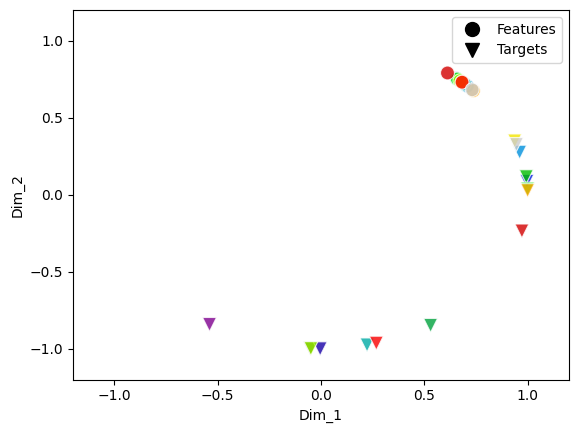

In [61]:
# time to cry
# I probably messed up the original loss. Went over it multiple times
import matplotlib.lines as mlines

sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Features')
sns.scatterplot(emb_targets, x = 'Dim_1', marker = 'v', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Targets')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

feature_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Features')
target_handle = mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=10, label='Targets')

plt.legend(handles=[feature_handle, target_handle])